In [1]:
import pandas as pd
import nltk;
from utils import lemmatize, remove_stop_words, replace_common_tech_words, remove_unnecessary_signs
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Download required NLTK data
nltk.download('wordnet');
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger');
nltk.download('omw-1.4');

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('labeled_tasks.csv')
df.drop(columns=["annotation_id","annotator","created_at","id","lead_time","updated_at"], inplace=True)

### Data preparation

In [3]:
def clean_text(text):
    text = replace_common_tech_words(text)
    text = lemmatize(text)
    text = remove_unnecessary_signs(text)
    text = remove_stop_words(text)
    return text

# Apply the cleaning function to your text column
df['cleaned_text'] = df['Question'].apply(clean_text)
df.drop(columns=["Question"], inplace=True)
# Uncomment to save the cleaned data to a csv file
# df.to_csv("./here.csv",index=False);
# df = pd.read_csv('here.csv')

In [4]:
# Encode the labels so that they are "friendly" for the model
one_hot_labels = pd.get_dummies(df['Category'])

In [5]:
tokenizer = Tokenizer()
def tokenize(df, tokenizer=tokenizer):
    # Assign to each distinct word a unique integer
    tokenizer.fit_on_texts(df)
    # For each text sample, replace each word with its corresponding unique integer
    sequences = tokenizer.texts_to_sequences(df)
    # Get vocab size for embedding layer
    # Pad each sequence to the same length, so that we can feed it to the neural network (all samples should have the same shape)
    return pad_sequences(sequences, maxlen=45) # max length of a text sample is 45 words
padded_sequences = tokenize(df['cleaned_text'])

In [6]:

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

# Further split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [7]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
model = Sequential(
    [
        # size of vocabulary is 1049
        Embedding(input_dim=vocab_size, output_dim=32, input_length=45),
        # Dropout layer to prevent overfitting.
        Dropout(0.5),
        LSTM(128),
        # Dropout layer to prevent overfitting.
        Dropout(0.5),
        # there are 7 classes
        Dense(7, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 32)            33600     
                                                                 
 dropout (Dropout)           (None, 45, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 116935 (456.78 KB)
Trainable params: 116935 (456.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])

Epoch 1/100


9/9 [==============================] - 7s 217ms/step - loss: 1.9069 - accuracy: 0.3220 - val_loss: 1.6842 - val_accuracy: 0.3977
Epoch 2/100
9/9 [==============================] - 1s 66ms/step - loss: 1.6413 - accuracy: 0.3485 - val_loss: 1.5024 - val_accuracy: 0.4659
Epoch 3/100
9/9 [==============================] - 1s 64ms/step - loss: 1.6303 - accuracy: 0.3636 - val_loss: 1.4183 - val_accuracy: 0.3636
Epoch 4/100
9/9 [==============================] - 1s 69ms/step - loss: 1.5953 - accuracy: 0.3788 - val_loss: 1.4462 - val_accuracy: 0.4091
Epoch 5/100
9/9 [==============================] - 1s 69ms/step - loss: 1.5899 - accuracy: 0.3712 - val_loss: 1.4172 - val_accuracy: 0.3864
Epoch 6/100
9/9 [==============================] - 1s 65ms/step - loss: 1.5563 - accuracy: 0.4318 - val_loss: 1.3926 - val_accuracy: 0.4773
Epoch 7/100
9/9 [==============================] - 1s 69ms/step - loss: 1.5033 - accuracy: 0.4470 - val_loss: 1.3731 - val_accuracy: 0.6136
Epoch 8/100
9/9 [

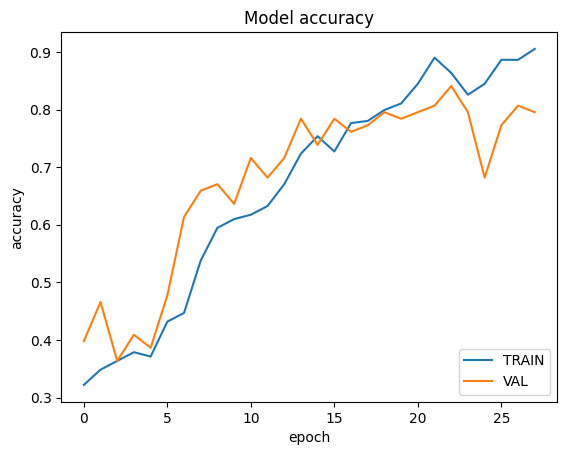

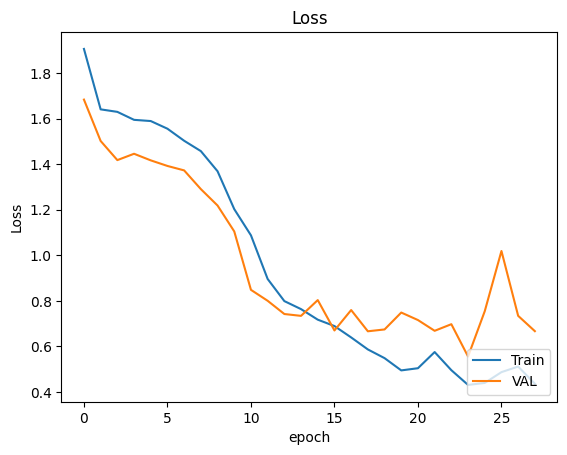

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'VAL'], loc='lower right')
plt.show()

3/3 [==============================] - 1s 25ms/step
                      precision    recall  f1-score   support

            Computer       0.39      0.60      0.47        15
   Computer Networks       0.89      0.76      0.82        33
           IT Basics       0.00      0.00      0.00         3
               Legal       0.00      0.00      0.00         3
OS or Administration       0.78      0.93      0.85        30
              Others       0.00      0.00      0.00         2
         Peripherals       0.00      0.00      0.00         2

            accuracy                           0.70        88
           macro avg       0.29      0.33      0.31        88
        weighted avg       0.67      0.70      0.68        88



c:\Users\macie\Coding Projects\NLP Demo\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macie\Coding Projects\NLP Demo\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\macie\Coding Projects\NLP Demo\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

''

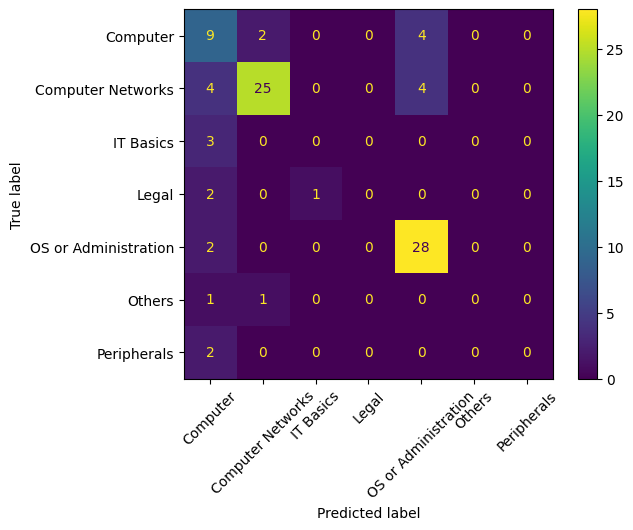

In [10]:
labels = labels = ['Computer', 'Computer Networks', 'IT Basics', 'Legal', 'OS or Administration', 'Others', 'Peripherals']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
ax = disp.plot().ax_
ax.set_xticklabels(labels, rotation=45)
print(classification_report(y_test2, y_pred, target_names=labels))
;

In [37]:
# Predict your own text
text = "monitor is connected"
text = clean_text(text)
text = tokenize([text])
prediction = np.argmax(model.predict(text), axis=1)
print(labels[prediction[0]])

1/1 [==============================] - 0s 44ms/step
Computer Networks
